## 1.4 ASHRAE-Harf and Harf## 1.3 EDA for ASHRAE

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2022.06.27 </div> 
<div style="text-align: right"> Last update: 2022.06.27</div> 

- https://www.kaggle.com/code/rohanrao/ashrae-half-and-half

### 라이브러리 import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150

In [2]:
import gc
import random

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [3]:
myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

데이터를 반반으로 나누고 FE를 최소화 했는데 성능이 잘 나오는 것을 보임

### Loading data

In [5]:
print(os.listdir('data/ashrae-energy-prediction/'))

['building_metadata.csv', 'sample_submission.csv', 'test.csv', 'test_df.pkl', 'train.csv', 'train_df.pkl', 'weather_test.csv', 'weather_train.csv']


In [6]:
path_data = 'data/ashrae-energy-prediction/'

path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

In [7]:
df_train = pd.read_csv(path_train)
building = pd.read_csv(path_building)
weather_train = pd.read_csv(path_weather_train)

In [8]:
df_train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [9]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [10]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


building 컬럼의 primary_use를 인코딩

In [11]:
le = LabelEncoder()
building['primary_use'] = le.fit_transform(building['primary_use'])

In [12]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


메모리 줄이기

In [13]:
## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [14]:
%%time
df_train = reduce_mem_usage(df_train, use_float16=True)
building = reduce_mem_usage(building, use_float16=True)
weather_train = reduce_mem_usage(weather_train, use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.84 MB
Decreased by 71.8%
Memory usage of dataframe is 0.06 MB
Memory usage after optimization is: 0.02 MB
Decreased by 72.6%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.59 MB
Decreased by 73.1%
CPU times: total: 1.02 s
Wall time: 1.02 s


### Preparing data

데이터에 병합할 파일, 피처가 두가지가 있다. 하나는 building metadata, 나머지 하나는 weather data 이다.

In [15]:
def prepare_data(X, building_data, weather_data, test = False):
    
    X = X.merge(building_data, on = 'building_id', how = 'left')
    X = X.merge(weather_data, on = ['site_id', 'timestamp'], how = 'left')
    
    X['timestamp'] = pd.to_datetime(X['timestamp'], format = '%Y-%m-%d %H:%M:%S')
    X['square_feet'] = np.log1p(X['square_feet'])
    
    if not test:
        X.sort_values('timestamp', inplace = True)
        X.reset_index(drop = True, inplace = True)
        
    gc.collect()
    
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X['is_holiday']  = (X['timestamp'].dt.date.astype('str').isin(holidays)).astype(int)
    
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed"]

    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        
        return X, row_ids
    
    else:
        y = np.log1p(X['meter_reading'])
        X.drop("meter_reading", axis=1, inplace=True)
        
        return X, y

In [16]:
X_train, y_train = prepare_data(df_train, building, weather_train)

del df_train, weather_train
gc.collect()

41

### Two-fold LightGBM Model split half-and-half

In [17]:
X_train.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekday,is_holiday
0,0,0,0,0,8.913685,2008.0,NaN,25.000000,6.0,20.000000,NaN,0,4,1
1,1104,1,13,9,12.204687,NaN,NaN,-8.296875,8.0,-12.203125,NaN,0,4,1
2,1104,0,13,9,12.204687,NaN,NaN,-8.296875,8.0,-12.203125,NaN,0,4,1
3,1103,0,13,7,10.081801,NaN,NaN,-8.296875,8.0,-12.203125,NaN,0,4,1
4,1102,2,13,6,11.375822,NaN,NaN,-8.296875,8.0,-12.203125,NaN,0,4,1


In [18]:
X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

In [19]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday"]

In [20]:
d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

In [21]:
watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

In [22]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

In [23]:
print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1000, valid_sets=watchlist_1, 
                         verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1000, valid_sets=watchlist_2, 
                         verbose_eval=200, early_stopping_rounds=200)

Building model with first half and validating on second half:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2396
[LightGBM] [Info] Number of data points in the train set: 10108050, number of used features: 14
[LightGBM] [Info] Start training from score 4.032965
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 0.922617	valid_1's rmse: 1.34044
[400]	training's rmse: 0.866348	valid_1's rmse: 1.33893
Early stopping, best iteration is:
[312]	training's rmse: 0.884907	valid_1's rmse: 1.3371
Building model with second half and validating on first half:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you ca

### Feature Importance

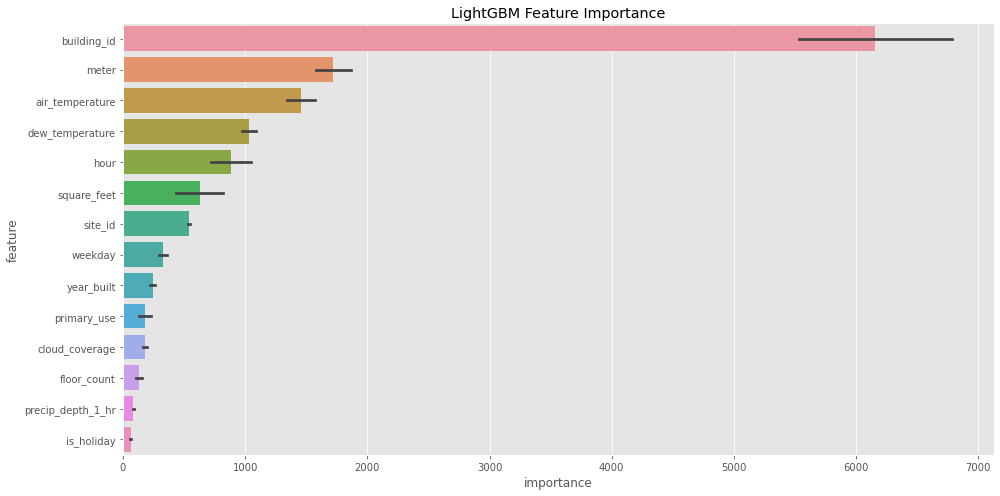

In [24]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = model_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = model_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [25]:
del X_train, y_train, X_half_1, X_half_2, y_half_1, y_half_2, d_half_1, d_half_2, watchlist_1, watchlist_2, df_fimp_1, df_fimp_2, df_fimp
gc.collect()

5308

### Preparing test data

In [26]:
path_test

'data/ashrae-energy-prediction/test.csv'

In [27]:
df_test = pd.read_csv(path_test)
weather_test = pd.read_csv(path_weather_test)

df_test = reduce_mem_usage(df_test)
weather_test = reduce_mem_usage(weather_test)

X_test, row_ids = prepare_data(df_test, building, weather_test, test=True)

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.53 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 8.83 MB
Decreased by 53.6%


In [28]:
del df_test, building, weather_test
gc.collect()

41

### Scoring test data

In [29]:
pred = np.expm1(model_half_1.predict(X_test, num_iteration=model_half_1.best_iteration)) / 2

del model_half_1
gc.collect()

pred += np.expm1(model_half_2.predict(X_test, num_iteration=model_half_2.best_iteration)) / 2
    
del model_half_2
gc.collect()

4

In [30]:
pred

array([ 92.92736085,  41.23321373,   3.82452726, ...,   3.68305423,
       187.50793008,  19.60156012])

In [31]:
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv("submission.csv", index=False)